In [1]:
import csv
import math
import os
import pickle
import re

import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import tensorflow as tf
from joblib import dump, load
from collections import Counter
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from keras.layers import LSTM, Dropout, Dense, Input


import ltn
import wandb


dataset_path = '/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU'

PGB_path = '/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/PGB/PGB'
RGB_path = '/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/RGB/RGB'

# Specify the CSV file path
csv_file = '/home/ubuntu/dds_paper/DDS_Paper/data/data_robust.csv'
preprocessor_file = 'preprocessor.joblib'

train_path = '/home/ubuntu/dds_paper/DDS_Paper/data/train.csv'
val_path = '/home/ubuntu/dds_paper/DDS_Paper/data/val.csv'

np.random.seed(45)

# Set the chunk size for reading the CSV
chunk_size = 100000  # Adjust the chunk size according to your memory limitations


# Directory containing your scaled CSV files
csv_directory = '/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs'
# Define your dataset directory
data_root_folder = '/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/PGB/PGB'

sequence_length = 30  # Example: Define your desired sequence length
sequences_directory = "/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs/sequences"
num_features = 8  # Based on the original number of features before sequencing


2024-03-20 10:10:10.455229: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 10:10:10.467346: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 10:10:10.585818: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 10:10:19.129033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def extract_fault(file_name):
    fault_mapping = {
        '0Health': 'HEA', '1Chipped': 'CTF', '2Miss': 'MTF', 
        '3Root': 'RCF', '4Surface': 'SWF', '5Ball': 'BWF', 
        '6Combination': 'CWF', '7Inner': 'IRF', '8Outer': 'ORF'
    }
    for key, value in fault_mapping.items():
        if key in file_name:
            return value
    return None

def make_csv_writer(csv_file):
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Channel1', 'Channel2', 'Channel3', 'Channel4', 'Channel5', 'Channel6', 'Channel7', 'Channel8', 'Fault'])
    return csv_writer

def generate_csv(output_directory, root_path, speed, experiment, files):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    train_filename_suffix = f"{speed}_{experiment}_train" if experiment else f"{speed}_train"
    test_filename_suffix = f"{speed}_{experiment}_test" if experiment else f"{speed}_test"
    
    train_output_file_path = os.path.join(output_directory, f"PGB_{train_filename_suffix}.csv")
    test_output_file_path = os.path.join(output_directory, f"PGB_{test_filename_suffix}.csv")
    
    with open(train_output_file_path, 'w', newline='', encoding='utf-8') as train_csvfile, \
        open(test_output_file_path, 'w', newline='', encoding='utf-8') as test_csvfile:
        train_csv_writer = make_csv_writer(train_csvfile)
        test_csv_writer = make_csv_writer(test_csvfile)
        
        for file in tqdm(files, desc=f"Processing {speed} {experiment}", unit="file"):
            fault_type = extract_fault(file)
            # Only append 'speed' directory for non-variable speed cases
            if experiment:
                file_path = os.path.join(root_path, file)  # Already includes 'Variable_speed/Experiment#'
            else:
                file_path = os.path.join(root_path, file)  # 'root_path' already includes 'speed' directory
            
            data = pd.read_csv(file_path, sep='\t', header=None, encoding='ISO-8859-1', skiprows=1, nrows=1000)
            train_samples, test_samples = data.iloc[:800, :], data.iloc[800:1000, :]
            
            for index, row in train_samples.iterrows():
                train_csv_writer.writerow(row[:8].tolist() + [fault_type])
            
            for index, row in test_samples.iterrows():
                test_csv_writer.writerow(row[:8].tolist() + [fault_type])

def process_pgb_data(data_root_folder, csv_directory):
    for root, dirs, files in os.walk(data_root_folder):
        parts = root.split(os.sep)
        if 'Variable_speed' in parts:
            speed = "Variable_speed"
            experiment_dir = parts[-1]  # Get the last part as the experiment name
            exp_files = [f for f in os.listdir(root) if f.endswith('.txt')]
            # Pass the 'root' directly without modifying it for variable speed
            generate_csv(csv_directory, root, speed, experiment_dir, exp_files)
        elif 'PGB' in parts and files:
            speed = parts[-1]  # Last part of 'root' is the speed directory
            # For non-variable speed, pass the 'root' directly
            generate_csv(csv_directory, root, speed, '', files)



process_pgb_data(data_root_folder, csv_directory)

Processing Variable_speed Variable_speed: 0file [00:00, ?file/s]


Processing 30_1 : 100%|██████████| 9/9 [00:01<00:00,  7.15file/s]


In [2]:
def overview_csv_files(directory):
    data = []
    all_faults = set()

    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)

            # Check if the CSV is empty (aside from the header)
            if df.shape[0] == 0:
                # Delete the empty CSV file
                os.remove(file_path)
                print(f"Deleted empty file: {file_path}")
                continue  # Skip further processing for this file

            num_samples = len(df)
            fault_distribution = Counter(df['Fault'])
            all_faults.update(fault_distribution.keys())
            data.append({'File Name': file, 'Number of Samples': num_samples, **fault_distribution})

    if not data:  # If no data has been gathered, exit the function
        print("No data found.")
        return

    overview_df = pd.DataFrame(data)
    for fault in all_faults:
        if fault not in overview_df.columns:
            overview_df[fault] = 0

    cols = ['File Name', 'Number of Samples'] + sorted(all_faults)
    overview_df = overview_df[cols]
    overview_df.fillna(0, inplace=True)
    overview_df.loc[:, 'Number of Samples':] = overview_df.loc[:, 'Number of Samples':].astype(int)

    overview_df = overview_df.sort_values(by='File Name')
    print(overview_df.to_string(index=False))

overview_csv_files(csv_directory)

No data found.


In [6]:
def load_and_scale_data(csv_path, scaler=None, save_scaler_path=None):
    """
    Loads data from a CSV file, scales the features (excluding the 'Fault' column), 
    and returns the scaled DataFrame. Optionally saves the scaler model.
    """
    # Load the data
    data = pd.read_csv(csv_path)
    
    # Separate features and target
    features = data.columns[:-1]  # Assuming the last column is the target
    X = data[features]
    y = data['Fault']

    # Apply scaling
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        if save_scaler_path:
            joblib.dump(scaler, save_scaler_path)
    else:
        X_scaled = scaler.transform(X)
    
    # Combine scaled features with target
    scaled_df = pd.DataFrame(X_scaled, columns=features)
    scaled_df['Fault'] = y
    
    return scaled_df



# Iterate over your dataset files
for root, dirs, files in os.walk(csv_directory):
    for file in sorted(files):
        if file.endswith('.csv') and not file.endswith('_scaled.csv'):  # Process only unscaled .csv files
            csv_path = os.path.join(root, file)
            if 'train' in file:
                # Handle training data
                scaler_path = os.path.join(root, 'scaler_' + file.replace('.csv', '.joblib'))
                scaled_train_df = load_and_scale_data(csv_path, save_scaler_path=scaler_path)
                # Save the scaled training data
                scaled_csv_path = csv_path.replace('.csv', '_scaled.csv')
                scaled_train_df.to_csv(scaled_csv_path, index=False)
            elif 'test' in file:
                # Handle testing data
                scaler_path = os.path.join(root, 'scaler_' + file.replace('_test.csv', '_train.joblib'))
                scaler = joblib.load(scaler_path) if os.path.exists(scaler_path) else None
                scaled_test_df = load_and_scale_data(csv_path, scaler=scaler)
                # Save the scaled testing data
                scaled_csv_path = csv_path.replace('.csv', '_scaled.csv')
                scaled_test_df.to_csv(scaled_csv_path, index=False)

            # Delete the original unscaled .csv file
            os.remove(csv_path)


In [7]:
def create_sequences(df, sequence_length):
    sequences = []
    labels = []
    fault_types = df['Fault'].unique()

    for fault in fault_types:
        df_fault = df[df['Fault'] == fault]
        X = df_fault.drop('Fault', axis=1).values
        y = df_fault['Fault'].iloc[0]  # Updated to use iloc for consistency
        
        for i in range(len(df_fault) - sequence_length + 1):
            sequences.append(X[i:i+sequence_length])
            labels.append(fault)  # Keep the fault type as is
    
    return np.array(sequences), np.array(labels)


def save_sequences(input_directory, output_directory, sequence_length):
    """
    Generates sequences and saves them as NumPy files, one for sequences and one for labels.
    
    Parameters:
    - input_directory: The directory with the original, scaled data files.
    - output_directory: The directory where the NumPy sequence files will be saved.
    - sequence_length: The number of consecutive samples in each sequence.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    for file_name in tqdm(os.listdir(input_directory), desc="Generating sequences"):
        if file_name.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_directory, file_name))
            sequences, labels = create_sequences(df, sequence_length)
            
            # File names for sequences and labels
            base_name = os.path.splitext(file_name)[0]
            sequences_file_path = os.path.join(output_directory, f"{base_name}_sequences.npy")
            labels_file_path = os.path.join(output_directory, f"{base_name}_labels.npy")
            
            # Save sequences and labels
            np.save(sequences_file_path, sequences)
            np.save(labels_file_path, labels)


save_sequences(csv_directory, sequences_directory, sequence_length)

Generating sequences: 100%|██████████| 58/58 [00:01<00:00, 47.32it/s]


In [8]:
def extract_speed_from_filename(file_name):
    """
    Extracts the speed from the filename.
    Returns the numeric speed for fixed speeds, or -1 for variable speeds.
    """
    fixed_speed_match = re.search(r"PGB_(\d+)_", file_name)
    if fixed_speed_match:
        return int(fixed_speed_match.group(1))
    variable_speed_match = re.search(r"Variable_speed", file_name)
    if variable_speed_match:
        return -1  # Special value for variable speeds
    return None

def add_speed_feature_and_save(input_directory, output_directory, sequence_length):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    for file_name in tqdm(os.listdir(input_directory), desc="Processing files"):
        if file_name.endswith('.csv'):
            speed = extract_speed_from_filename(file_name)
            df = pd.read_csv(os.path.join(input_directory, file_name))
            df['Speed'] = speed  # Add speed as a new column
            
            sequences, labels = create_sequences(df, sequence_length)
            
            base_name = os.path.splitext(file_name)[0]
            sequences_file_path = os.path.join(output_directory, f"{base_name}_sequences.npy")
            labels_file_path = os.path.join(output_directory, f"{base_name}_labels.npy")
            
            np.save(sequences_file_path, sequences)
            np.save(labels_file_path, labels)

# Remember to replace `input_directory`, `output_directory`, and `sequence_length` with your actual values
add_speed_feature_and_save(csv_directory, sequences_directory, sequence_length)


Processing files: 100%|██████████| 58/58 [00:01<00:00, 42.05it/s]


In [10]:
def display_samples(sequences_file_path, labels_file_path, num_samples=1):
    """
    Displays a specified number of samples from the sequences and labels .npy files.
    
    Parameters:
    - sequences_file_path: Path to the .npy file containing sequences.
    - labels_file_path: Path to the .npy file containing labels.
    - num_samples: Number of samples to display. Default is 5.
    """
    # Load the sequences and labels
    sequences = np.load(sequences_file_path)
    labels = np.load(labels_file_path)
    
    # Determine the number of samples to display (cannot exceed the length of the data)
    num_samples = min(num_samples, len(sequences))
    
    # Display the specified number of samples
    for i in range(num_samples):
        print(f"Sample {i+1}:")
        print("Sequence:")
        print(sequences[i])
        print("Label:")
        print(labels[i])
        print("-" * 50)  # Separator for readability

# Example usage:

#display_samples('/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs/sequences/PGB_Variable_speed_Experiment10_train_scaled_sequences.npy', '/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs/sequences/PGB_Variable_speed_Experiment10_test_scaled_labels.npy', num_samples=1)


Sample 1:
Sequence:
[[ 0.8001289  -0.31234846 -0.08071305  0.03526632 -1.36544478 -0.09371
   0.10288366  0.59093989 -1.        ]
 [ 0.7938483  -0.26989087 -0.19563853 -0.06400364 -1.33334195 -0.78049913
  -0.62416221 -0.11157456 -1.        ]
 [ 0.78421284 -0.40112343 -0.10723432 -0.08173042 -1.23893428 -0.01211129
  -0.18264708  0.60778099 -1.        ]
 [ 0.78175522 -0.44358103  0.17565918 -0.35117746 -1.26068817 -0.73969978
  -0.54749192  0.01112488 -1.        ]
 [ 0.77820531 -0.55937446  0.06957412 -0.05336757 -1.2399903  -0.5799023
  -0.44173979  0.19637698 -1.        ]
 [ 0.77890749 -0.15409743  0.19334002 -0.23418072 -1.32848428 -0.16170892
  -0.04781312  0.76897437 -1.        ]
 [ 0.78171621 -0.6134114  -0.47411182 -0.43272065 -1.47632627 -0.61390177
  -0.49197205 -0.17653309 -1.        ]
 [ 0.7852271  -0.28533    -0.3061438  -0.28736106 -1.44021058 -0.10730978
  -0.10333299  0.55725769 -1.        ]
 [ 0.78901107 -0.22743328 -0.17353748 -0.41499387 -1.38360822  0.22928489
  -0.0

In [9]:
def memmap_append_and_save(input_directory, output_directory, dataset_type, file_type):
    # Update the output file path to indicate pickle format
    output_file_path = os.path.join(output_directory, f"{dataset_type}_merged_{file_type}.pkl")

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    merged_data = None
    current_size = 0

    file_names = [fn for fn in os.listdir(input_directory) if fn.endswith(f'_{file_type}.npy') and dataset_type in fn]
    for file_name in tqdm(file_names, desc=f"Merging {dataset_type} {file_type}"):
        path = os.path.join(input_directory, file_name)
        data = np.load(path)

        # Adjust for both 1D and 2D+ data
        new_shape = (current_size + data.shape[0],) + data.shape[1:] if len(data.shape) > 1 else (current_size + data.shape[0],)
        if merged_data is None:
            # Initially, directly use the loaded data
            merged_data = data.copy()
        else:
            # Concatenate new data
            merged_data = np.concatenate((merged_data, data), axis=0)
        
        current_size += data.shape[0]

    # After processing all files, save the merged data using pickle
    with open(output_file_path, 'wb') as f:
        pickle.dump(merged_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    print(f"{dataset_type.capitalize()} {file_type} data merged and saved to {output_file_path} in pickle format")

def merge_npy_files_with_memmap_separated(input_directory, output_directory):
    for dataset_type in ['train', 'test']:
        for file_type in ['sequences', 'labels']:
            memmap_append_and_save(input_directory, output_directory, dataset_type, file_type)


# Replace `input_directory` and `output_directory` with your actual paths
merge_npy_files_with_memmap_separated(sequences_directory, sequences_directory)


Merging train sequences: 100%|██████████| 19/19 [00:00<00:00, 24.01it/s]


Train sequences data merged and saved to /home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs/sequences/train_merged_sequences.pkl in pickle format


Merging train labels: 100%|██████████| 19/19 [00:00<00:00, 2848.37it/s]


Train labels data merged and saved to /home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs/sequences/train_merged_labels.pkl in pickle format


Merging test sequences: 100%|██████████| 19/19 [00:00<00:00, 119.33it/s]


Test sequences data merged and saved to /home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs/sequences/test_merged_sequences.pkl in pickle format


Merging test labels: 100%|██████████| 19/19 [00:00<00:00, 3826.18it/s]

Test labels data merged and saved to /home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs/sequences/test_merged_labels.pkl in pickle format


In [3]:
# version that takes speed by speed

def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.1
    return lr

def load_sequences(sequence_file_path, label_file_path):
    sequences = np.load(sequence_file_path)
    labels = np.load(label_file_path)
    encoder = LabelEncoder()
    labels_encoded = encoder.fit_transform(labels)
    labels_onehot = to_categorical(labels_encoded)
    return sequences, labels_onehot

# def create_model(input_shape, num_classes):
#     model = Sequential([
#         LSTM(100, return_sequences=True, input_shape=input_shape),
#         Dropout(0.2),
#         LSTM(100),
#         Dropout(0.2),
#         Dense(100, activation='relu'),
#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

def create_model(input_shape, num_classes, l2_reg=0.001):
    model = Sequential([
        LSTM(256, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(l2_reg)),
        Dropout(0.3),
        LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),
        Dropout(0.3),
        LSTM(64, kernel_regularizer=l2(l2_reg)),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Prepare a list of base names to avoid redundancy
processed_bases = set()

# Iterate through the directory to find matching train and test pairs
for file in sorted(os.listdir(sequences_directory)):
    if "_train_scaled_sequences.npy" in file:
        base_name = file.replace("_train_scaled_sequences.npy", "")
        if base_name in processed_bases:
            continue  # Skip if this set has already been processed

        train_sequence_file_path = os.path.join(sequences_directory, f"{base_name}_train_scaled_sequences.npy")
        train_label_file_path = os.path.join(sequences_directory, f"{base_name}_train_scaled_labels.npy")
        test_sequence_file_path = os.path.join(sequences_directory, f"{base_name}_test_scaled_sequences.npy")
        test_label_file_path = os.path.join(sequences_directory, f"{base_name}_test_scaled_labels.npy")

        # Check if corresponding test files exist
        if os.path.exists(test_sequence_file_path) and os.path.exists(test_label_file_path):
            print(f"Processing: {base_name}")
            X_train, y_train = load_sequences(train_sequence_file_path, train_label_file_path)
            X_test, y_test = load_sequences(test_sequence_file_path, test_label_file_path)

            num_classes = y_train.shape[1]
            input_shape = (sequence_length, num_features)
            
            model = create_model(input_shape, num_classes)
            lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)
            early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

            model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=512, callbacks=[early_stopping, lr_scheduler], verbose=1)
            
            processed_bases.add(base_name)  # Mark this set as processed



Processing: PGB_20_0


/home/ubuntu/miniconda3/envs/ltn/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 9 and 8 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_2, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,9], [8,1024].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 9), dtype=float32)
  • states=('tf.Tensor(shape=(None, 256), dtype=float32)', 'tf.Tensor(shape=(None, 256), dtype=float32)')
  • training=True

In [2]:
#optimized version for all data

# from keras.models import Sequential
# from keras.layers import LSTM, Dropout, Dense, Input, BatchNormalization
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
# from keras.regularizers import l2
# from keras.utils import to_categorical
# from sklearn.preprocessing import LabelEncoder
# import pickle
# import time

# def lr_schedule(epoch, lr):
#     if epoch % 10 == 0 and epoch > 0:
#         return lr * 0.1
#     return lr

# def load_sequences(sequence_file_path, label_file_path):
#     # Load sequences using pickle
#     with open(sequence_file_path, 'rb') as f:
#         sequences = pickle.load(f)
#     # Load labels using pickle
#     with open(label_file_path, 'rb') as f:
#         labels = pickle.load(f)
    
#     encoder = LabelEncoder()
#     labels_encoded = encoder.fit_transform(labels)
#     labels_onehot = to_categorical(labels_encoded)
#     return sequences, labels_onehot

# def create_model(input_shape, num_classes, l2_reg=0.001):
#     model = Sequential([
#         Input(shape=input_shape),  # Use an Input layer to specify the input shape
#         LSTM(256, return_sequences=True, kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         LSTM(64, kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Update the paths to point to the pickle files
# train_sequence_file_path = os.path.join(sequences_directory, 'train_merged_sequences.pkl')
# train_label_file_path = os.path.join(sequences_directory, 'train_merged_labels.pkl')
# test_sequence_file_path = os.path.join(sequences_directory, 'test_merged_sequences.pkl')
# test_label_file_path = os.path.join(sequences_directory, 'test_merged_labels.pkl')

# def create_enhanced_model(input_shape, num_classes, l2_reg=0.001):
#     model = Sequential([
#         Input(shape=input_shape),
#         LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), dropout=0.3, recurrent_dropout=0.0),
#         BatchNormalization(),
#         LSTM(64, return_sequences=True, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), dropout=0.3, recurrent_dropout=0.0),
#         BatchNormalization(),
#         LSTM(32, return_sequences=False, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), dropout=0.3, recurrent_dropout=0.0),
#         BatchNormalization(),
#         Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         Dense(num_classes, activation='softmax')  # Use 'softmax' for multi-class classification
#     ])
#     return model

# # Model compilation with the Adam optimizer and learning rate scheduling
# def compile_and_train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    
#     # Define learning rate decay
#     lr_decay = ReduceLROnPlateau(monitor='loss', patience=1, verbose=1, factor=0.5, min_lr=1e-8)
    
#     # Define early stopping
#     early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=50, verbose=1, mode='auto', restore_best_weights=True)
    
#     start = time.time()
#     history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=True, verbose=1, callbacks=[lr_decay, early_stop])
    
#     print('-' * 65)
#     print(f'Training was completed in {time.time() - start:.2f} secs')
#     print('-' * 65)

#     # Evaluate the model
#     train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
#     test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    
#     print('-' * 65)
#     print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
#     print(f'test accuracy = {round(test_accuracy * 100, 4)}%')
#     print(f'test error = {round((1 - test_accuracy) * len(y_test))} out of {len(y_test)} examples')

# # Load sequences and labels
# X_train, y_train = load_sequences(train_sequence_file_path, train_label_file_path)
# X_test, y_test = load_sequences(test_sequence_file_path, test_label_file_path)

# # Create and train the enhanced model
# enhanced_model = create_enhanced_model(input_shape=X_train.shape[1:], num_classes=y_train.shape[1], l2_reg=0.001)
# compile_and_train_model(enhanced_model, X_train, y_train, X_test, y_test, epochs=100, batch_size=2056)


In [21]:
# Make predictions on the test set
predictions = enhanced_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)


914/914 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step


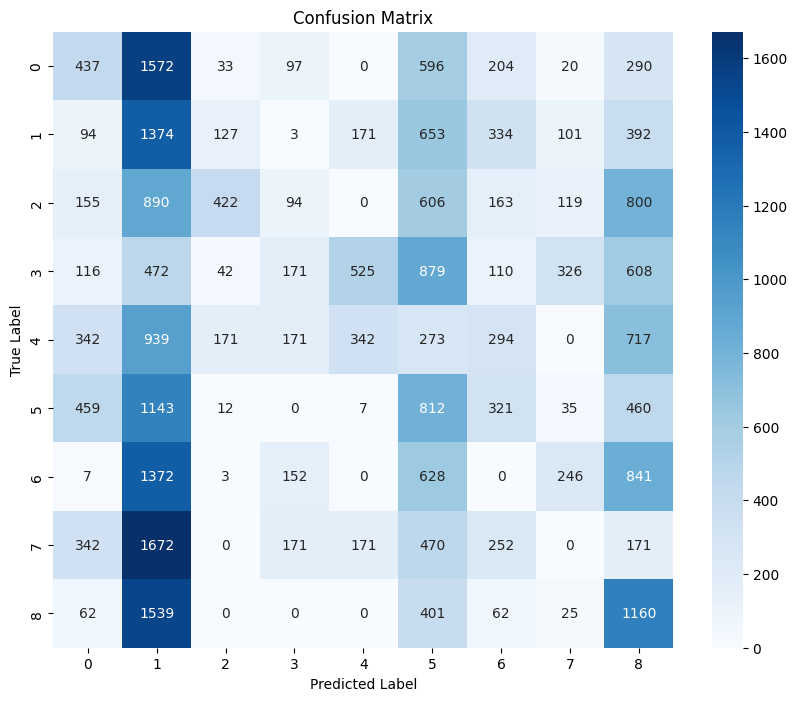

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [16]:
# Print some predictions and their true labels
for i in range(10):  # Adjust the range as needed
    print(f"Sample {i+1}: Predicted Class = {predicted_classes[i]}, True Class = {true_classes[i]}")


Sample 1: Predicted Class = 0, True Class = 5
Sample 2: Predicted Class = 0, True Class = 5
Sample 3: Predicted Class = 0, True Class = 5
Sample 4: Predicted Class = 0, True Class = 5
Sample 5: Predicted Class = 0, True Class = 5
Sample 6: Predicted Class = 0, True Class = 5
Sample 7: Predicted Class = 0, True Class = 5
Sample 8: Predicted Class = 0, True Class = 5
Sample 9: Predicted Class = 0, True Class = 5
Sample 10: Predicted Class = 0, True Class = 5


In [23]:
true_counts = np.sum(cm, axis=1)
for i, count in enumerate(true_counts):
    print(f"True instances of class {i}: {count}")
predicted_counts = np.sum(cm, axis=0)
for i, count in enumerate(predicted_counts):
    print(f"Predicted instances of class {i}: {count}")


True instances of class 0: 3249
True instances of class 1: 3249
True instances of class 2: 3249
True instances of class 3: 3249
True instances of class 4: 3249
True instances of class 5: 3249
True instances of class 6: 3249
True instances of class 7: 3249
True instances of class 8: 3249
Predicted instances of class 0: 2014
Predicted instances of class 1: 10973
Predicted instances of class 2: 810
Predicted instances of class 3: 859
Predicted instances of class 4: 1216
Predicted instances of class 5: 5318
Predicted instances of class 6: 1740
Predicted instances of class 7: 872
Predicted instances of class 8: 5439


In [3]:
## option for all data

# import numpy as np
# import pickle
# from keras.models import Sequential
# from keras.layers import LSTM, Dropout, Dense
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
# from keras.regularizers import l2
# from keras.utils import to_categorical
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import TimeSeriesSplit

# def lr_schedule(epoch, lr):
#     if epoch % 10 == 0 and epoch > 0:
#         return lr * 0.1
#     return lr

# class TestSetEvaluation(Callback):
#     def __init__(self, test_data, interval=5):
#         super(TestSetEvaluation, self).__init__()
#         self.test_data = test_data
#         self.interval = interval

#     def on_epoch_end(self, epoch, logs=None):
#         if epoch % self.interval == 0:
#             X_test, y_test = self.test_data
#             scores = self.model.evaluate(X_test, y_test, verbose=0)
#             print(f'\nTesting on test set every {self.interval} epochs - epoch: {epoch + 1}, test_loss: {scores[0]}, test_accuracy: {scores[1]}\n')

# def load_sequences(sequence_file_path, label_file_path):
#     with open(sequence_file_path, 'rb') as f:
#         sequences = pickle.load(f)
#     with open(label_file_path, 'rb') as f:
#         labels = pickle.load(f)
    
#     encoder = LabelEncoder()
#     labels_encoded = encoder.fit_transform(labels)
#     labels_onehot = to_categorical(labels_encoded)
#     return sequences, labels_onehot

# def create_model(input_shape, num_classes, l2_reg=0.001):
#     model = Sequential([
#         LSTM(256, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         LSTM(64, kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
#         Dropout(0.3),
#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Assuming 'sequences_directory' is defined
# train_sequence_file_path = os.path.join(sequences_directory, 'train_merged_sequences.pkl')
# train_label_file_path = os.path.join(sequences_directory, 'train_merged_labels.pkl')
# test_sequence_file_path = os.path.join(sequences_directory, 'test_merged_sequences.pkl')
# test_label_file_path = os.path.join(sequences_directory, 'test_merged_labels.pkl')

# # Load sequences and labels
# X_train, y_train = load_sequences(train_sequence_file_path, train_label_file_path)
# X_test, y_test = load_sequences(test_sequence_file_path, test_label_file_path)

# num_classes = y_train.shape[1]
# input_shape = X_train.shape[1:]

# # TimeSeriesSplit setup
# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)

# test_data = (X_test, y_test)

# for fold, (train_index, val_index) in enumerate(tscv.split(X_train), start=1):
#     print(f"Training on fold {fold}/{n_splits}...")
    
#     X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
#     y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
#     model = create_model(input_shape, num_classes, l2_reg=0.001)
    
#     lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)
#     early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
#     test_evaluation = TestSetEvaluation(test_data=test_data, interval=5)
    
#     model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
#             epochs=100, batch_size=512,
#             callbacks=[early_stopping, lr_scheduler, test_evaluation],
#             verbose=1)


Training on fold 1/5...


/home/ubuntu/miniconda3/envs/ltn/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.3819 - loss: 1.9356
Testing on test set every 5 epochs - epoch: 1, test_loss: 5.415952205657959, test_accuracy: 0.10852092504501343

444/444 ━━━━━━━━━━━━━━━━━━━━ 648s 1s/step - accuracy: 0.3820 - loss: 1.9350 - val_accuracy: 0.0695 - val_loss: 2.9775 - learning_rate: 0.0010
Epoch 2/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 201s 453ms/step - accuracy: 0.4360 - loss: 1.5262 - val_accuracy: 0.0702 - val_loss: 2.3040 - learning_rate: 0.0010
Epoch 3/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 207s 466ms/step - accuracy: 0.4386 - loss: 1.5071 - val_accuracy: 0.0702 - val_loss: 2.3028 - learning_rate: 0.0010
Epoch 4/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 205s 463ms/step - accuracy: 0.4179 - loss: 1.5825 - val_accuracy: 0.0702 - val_loss: 2.2752 - learning_rate: 0.0010
Epoch 5/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.4204 - loss: 1.5551

KeyboardInterrupt: 